# Quantum Generative Adversarial Networks

QGANs has two sub-circuits: a generator and a discriminator. The generator attempts to generate synthetic quantum data to match a pattern of “real” data, while the discriminator tries to discern real data from fake data.

<center>
    <figure>
        <img src="images/qgan_states_circuit.png" width=50%>
    </figure>
</center>

In [19]:
%matplotlib inline
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

dev = qml.device('cirq.simulator', wires=3)

## Generator and Discriminator

In GANs, we draw sample from *real data* distribution, or *fake data* from a generator, and use the discriminator to differentiate between them.

For this excercise, our real data will be a qubit that has been rotated (from starting point $|0\rangle$) to some arbitrary, but fixed state.

Both the real circuit and the generator will work on wire 0, which will be input to the discriminator, whose output will be wire 2. Wire 1 is workspace for the generator.

In [2]:
def real(angles):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

In [3]:
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)

def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

## QNodes for real and fake data

We create two QNodes, one for real data and the other for fake data. Both are followed by discriminator in their respective circuit.

In [22]:
@qml.qnode(dev)
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    qml.Barrier()
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    qml.Barrier()
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

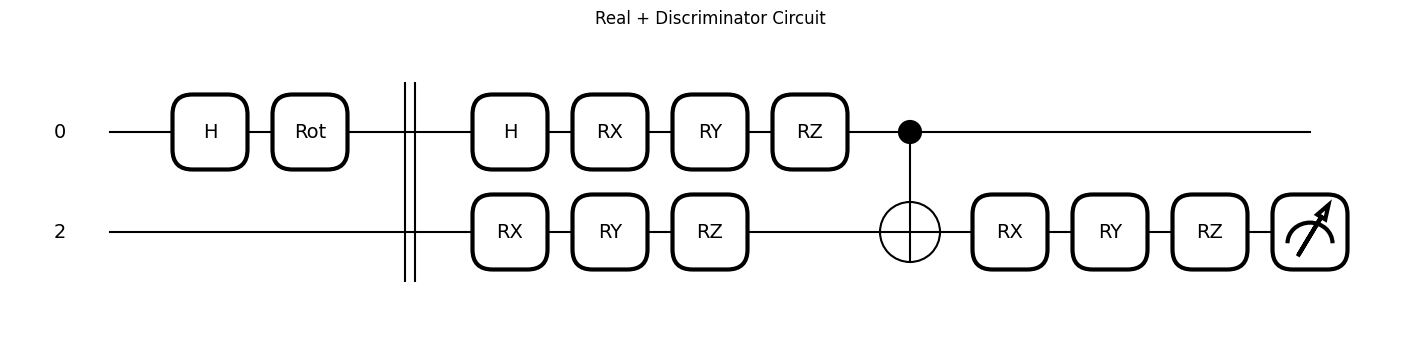

In [34]:
real_weights = np.random.random(3)
gene_weights = np.random.random(9)
disc_weights = np.random.random(9)

qml.draw_mpl(real_disc_circuit)(*real_weights, disc_weights)
plt.title("Real + Discriminator Circuit")
plt.show()

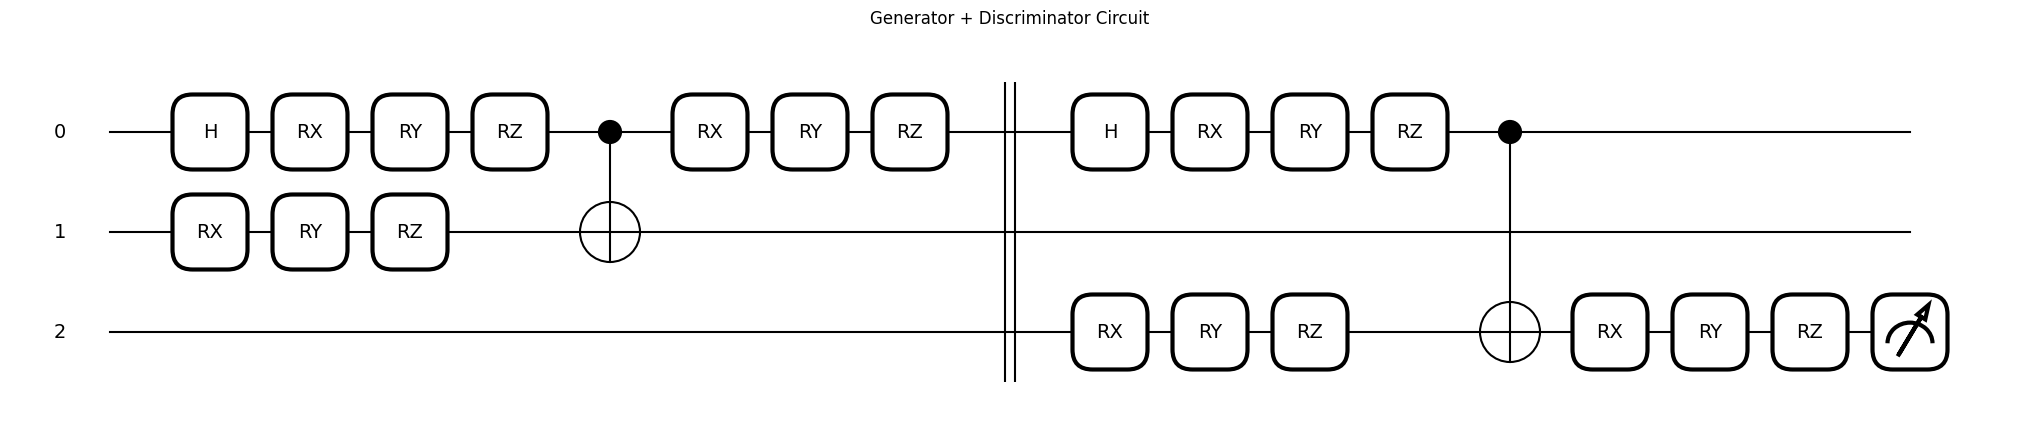

In [35]:
qml.draw_mpl(gen_disc_circuit)(gene_weights, disc_weights)
plt.title("Generator + Discriminator Circuit")
plt.show()

## Cost Functions

There will be two cost functions - one for generator and one for discriminator.

For discriminator, it will maximize the probability of correctly classifying real data, while minimizing the probability of mistakenly classifying fake data.

$$Cost_D = Pr(real|fake) - Pr(real|real)$$

For generator, it will maximize the probability that the discriminator accepts fake data as real.

$$Cost_G=-Pr(real|fake)$$

In [37]:
# the probability of real data classified as real
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true

# the probability of fake data classified as real
def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true

def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost

def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

## Training

In [39]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(42)
eps = 1e-2

# generator's initial state is close to |1> 
init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

In [40]:
opt = tf.keras.optimizers.SGD(0.4)
opt.build([disc_weights, gen_weights])

In the fist stage of training, we optimize the discriminator while keeping the generator parameter fixed.

In [42]:
# cost = lambda: disc_cost(disc_weights)

for step in range(50):
    # Compute the gradients.
    with tf.GradientTape() as tape:
        loss_value = disc_cost(disc_weights)
        
    # Update the variables.
    opt.apply_gradients(zip(tape.gradient(loss_value, [disc_weights]), [disc_weights]))
    
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = 0.13485214859247208
Step 5: cost = -0.024572551250457764
Step 10: cost = -0.19503089785575867
Step 15: cost = -0.41096214950084686
Step 20: cost = -0.4834216684103012
Step 25: cost = -0.49447527527809143
Step 30: cost = -0.49673910439014435
Step 35: cost = -0.4976443350315094
Step 40: cost = -0.49814239144325256
Step 45: cost = -0.4984353333711624


In [46]:
print(f"Prob(real classified as real): {prob_real_true(disc_weights).numpy():.4f}")
print(f"Prob(fake classified as real): {prob_fake_true(gen_weights, disc_weights).numpy():.4f}")

Prob(real classified as real): 0.9994
Prob(fake classified as real): 0.5009


In the *adversarial game* we now have to train the generator to better fool the discriminator.

In [47]:
for step in range(50):
    # Compute the gradients.
    with tf.GradientTape() as tape:
        loss_value = gen_cost(gen_weights)
        
    # Update the variables.
    opt.apply_gradients(zip(tape.gradient(loss_value, [gen_weights]), [gen_weights]))
    
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.41657133400440216
Step 5: cost = -0.10768511891365051
Step 10: cost = -0.02030518651008606
Step 15: cost = -0.004376918077468872
Step 20: cost = -0.0007613897323608398
Step 25: cost = 0.00019273161888122559
Step 30: cost = 0.0004564523696899414
Step 35: cost = 0.0005303025245666504
Step 40: cost = 0.0005511343479156494
Step 45: cost = 0.0005569159984588623


In [48]:
print(f"Prob(real classified as real): {prob_real_true(disc_weights).numpy():.4f}")
print(f"Prob(fake classified as real): {prob_fake_true(gen_weights, disc_weights).numpy():.4f}")
print(f"Discriminator cost: {disc_cost(disc_weights).numpy():.4f}")

Prob(real classified as real): 0.9994
Prob(fake classified as real): 1.0000
Discriminator cost: 0.0006


The generator has successfully learned to simulate the real data enough to fool the discriminator.

# Resources

- [QGANs tutorial - PennyLane](https://pennylane.ai/qml/demos/tutorial_QGAN/)